In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode 
from scipy.stats import norm
from scipy.stats import chi2_contingency
plt.style.use('ggplot')
from tqdm.auto import tqdm

In [3]:
plt.rcParams["figure.figsize"] = (15, 8)

#### Есть две группы пользователей, которым предлагали разные акционные предложения.  
#### Исследуем полученный доход по каждой группе.

In [4]:
# загружаем данные
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 

In [12]:
# проведём исследование данных
# вид таблицы:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [11]:
# посмотрим на пропущенные значения и на тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [15]:
# описательная статистика
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [18]:
# минимальные и максимальные значения в столбцах ведут себя нормально. Слишком больших или отрицательных значений нет.
# Итого: ошибок, пропусков - нет. Типы данных соответствуют предпологаемому наполнению.
# Распределение значений увидим при изучении данных в группах отдельно.

In [7]:
# Делим пользователей по группам
df_a = df.query("testgroup == 'a'")
df_b = df.query("testgroup == 'b'")

In [8]:
arpu_a = df_a.revenue.sum() / df_a.shape[0]
arpu_b = df_b.revenue.sum() / df_b.shape[0]
print(f'средний доход на пользователя в группе А = {arpu_a}')
print(f'средний доход на пользователя в группе B = {arpu_b}')
print(f'АРПУ в тестовой группе больше на {((arpu_b / arpu_a)-1) * 100}%')

средний доход на пользователя в группе А = 25.413719736965806
средний доход на пользователя в группе B = 26.75128659327863
АРПУ в тестовой группе больше на 5.263168360069903%


In [9]:
df_b_pu = df_b.query("revenue > 0")
df_a_pu = df_a.query("revenue > 0")
arppu_a = df_a_pu.revenue.sum() / df_a_pu.shape[0]
arppu_b = df_b_pu.revenue.sum() / df_b_pu.shape[0]
print(f'средний доход на платящего пользователя в группе А = {arppu_a}')
print(f'средний доход на платящего пользователя в группе B = {arppu_b}')
print(f'АРППУ в тестовой группе больше на {((arppu_b / arppu_a) - 1) * 100}%')

средний доход на платящего пользователя в группе А = 2663.9984439834025
средний доход на платящего пользователя в группе B = 3003.6581717451522
АРППУ в тестовой группе больше на 12.749997227996346%


In [10]:
# суммарная выручка по тестовых групп
print(f'суммарная выручка по группе А = {df_a.revenue.sum()}')
print(f'суммарная выручка по группе B = {df_b.revenue.sum()}')
print(f'выручка в группе B больше чем в группе А на {df_b.revenue.sum()-df_a.revenue.sum()}')

суммарная выручка по группе А = 5136189
суммарная выручка по группе B = 5421603
выручка в группе B больше чем в группе А на 285414


In [16]:
# велика ли разница в количеcтве человек в группах
cr_a = round(100 * df_a_pu.shape[0] / df_a.shape[0], 2)
cr_b = round(100 * df_b_pu.shape[0] / df_b.shape[0], 2)
diff_a_b = round(100 * df_b.shape[0] / df_a.shape[0] - 100, 2)

print(f'всего в группе А {df_a.shape[0]} человек, из них платящих {df_a_pu.shape[0]}({cr_a}%)')
print(f'всего в группе B {df_b.shape[0]} человек, из них платящих {df_b_pu.shape[0]}({cr_b}%)')
print(f'группа В больше А на {df_b.shape[0]-df_a.shape[0]} человек или на {diff_a_b}%')

всего в группе А 202103 человек, из них платящих 1928(0.95%)
всего в группе B 202667 человек, из них платящих 1805(0.89%)
группа В больше А на 564 человек или на 0.28%


#### Расхождения в группах есть, но не критичные

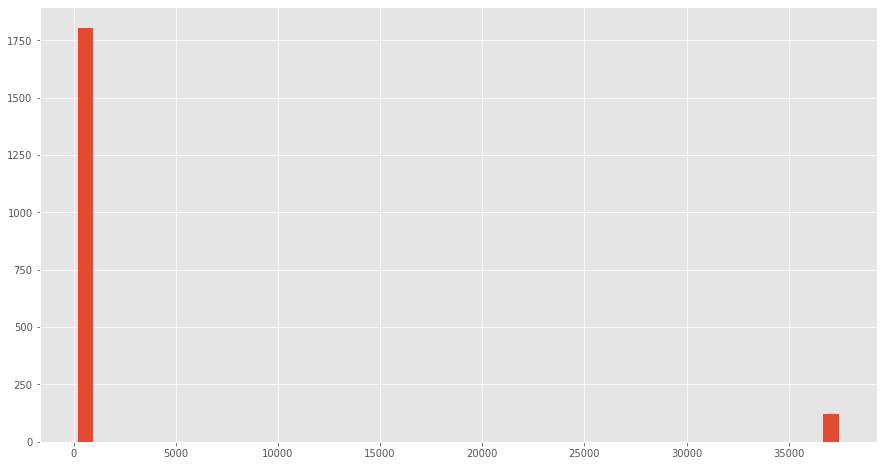

In [42]:
# Посмотрим на распределение сумм покупок в группе А
df_a_pu.revenue.hist(bins=50)

In [16]:
# посмотрим более детальную информацию по этому "выбросу"  
df_a_pu.query("revenue > 1000").revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

#### 123 человека совершили очень крупные покупки, больше чем на 37 000 у.е. каждый

In [50]:
# посчитаем какова доля этих 123 человек в общем доходе в группе
rev_123 = round(df_a_pu.query("revenue > 1000").revenue.sum() * 100 / df_a_pu.revenue.sum(), 2)
print(f'Эти 123 пользователя принесли {rev_123}% доходов')

Эти 123 пользователя принесли 89.37% доходов


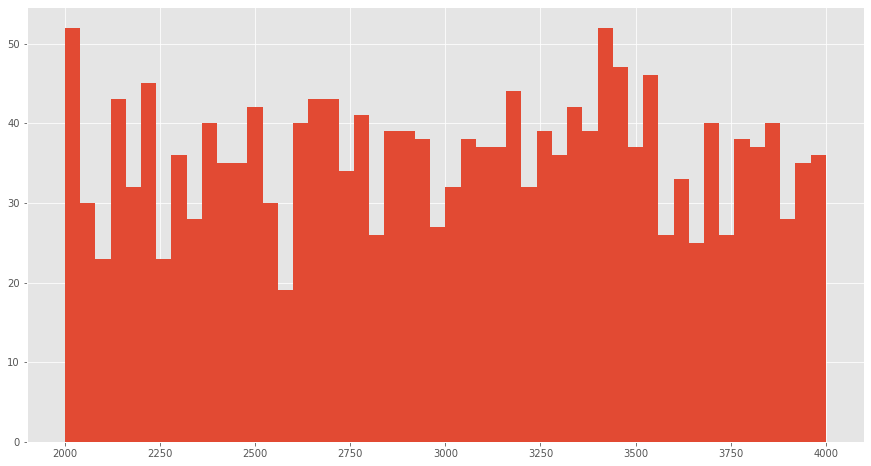

In [43]:
# Распределение сумм покупок в группе В
df_b_pu.revenue.hist(bins=50)

#### Исходя из этих распределений, можно предположить, что в первом случае акция была нацелена на единичных пользователей для совершения ими крупных (или большого количества) покупок (123 человека). А во втором - на поднятие доходов с массы пользователей, совершающих  относительно небольшие покупки.

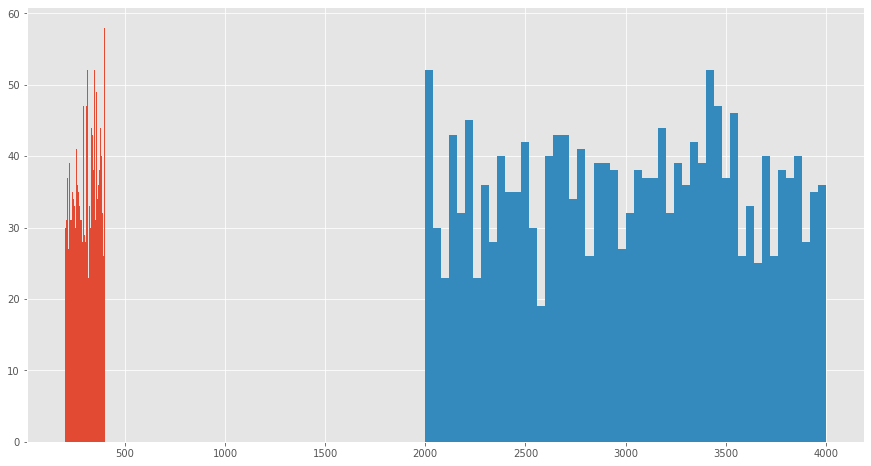

In [44]:
# визуализация разницы в суммах дохода с пользователей совершающих небольшие покупки в группах А и B.
df_a_pu.query("revenue < 1000").revenue.hist(bins=50)
df_b_pu.revenue.hist(bins=50)

#### В первом приближении вторая стратегия (увеличение чека большой массы пользователей) оказалась чуть эффективнее. АРПУ (ну и общая выручка) больше на 5%, АРППУ на 12%.  
#### Посмотрим, так ли это на самом деле с помощью статистических тестов.



#### Будем применять бутстрап при сравнении средних. Именно средних, т.к. медиана или другой квантиль не помогут оценить общий уровень дохода от группы. А для денег это очень важно.  
#### По этой же причине отметаем тест Манн-Уитни. Т.к. нам принципиально важно различие между средними значениями, а не формами распределения. К тому же, нормальной работе теста мешают повторяющиеся значения, а у нас значения дохода в обоих группах на 99% состоят из нулей.

#### За нулевую гипотезу примем, что средние в группах не имеют различий.  За альтернативную, что среднее во второй группе отличается от первой. Альфа - 0,05.

In [3]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=3000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_2) - statistic(samples_1))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

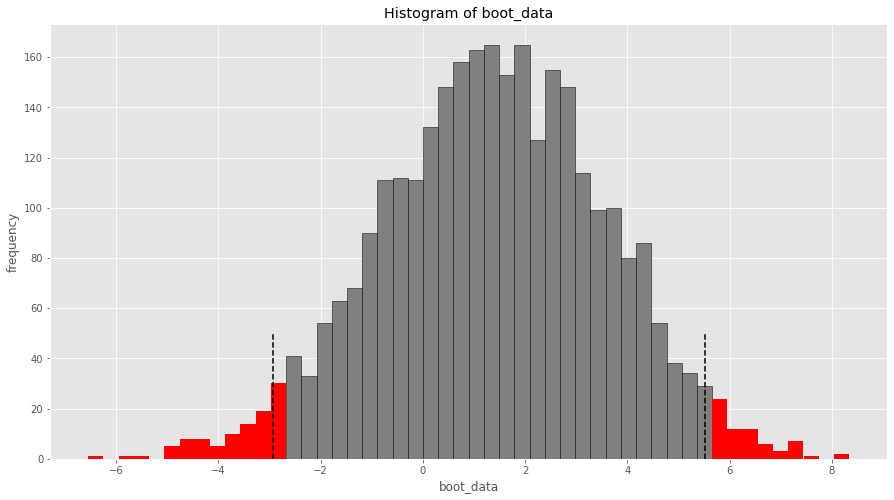

In [18]:
booted_data = get_bootstrap(df_a.revenue, df_b.revenue)

#### если нулевая гипотеза верна, шанс получить наши данные в группах составит:

In [19]:
print(f'{round(100*booted_data["p_value"], 2)}%')

52.77%


#### Что не даёт нам права отклонить нулевую гипотезу.

### Проведём сравнение только платящих пользователей

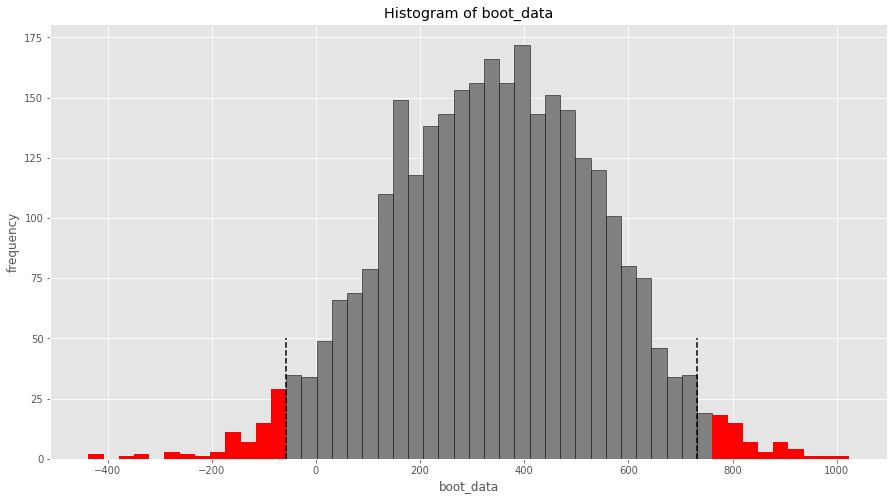

In [24]:
booted_data = get_bootstrap(df_a_pu.revenue, df_b_pu.revenue)

#### если нулевая гипотеза верна, шанс получить наши данные в группах составит:

In [25]:
print(f'{round(100*booted_data["p_value"], 2)}%')

9.51%


#### Что, опять же, не даёт нам права отклонить нулевую гиппотезу.

### Оценка различия конверсии в группах

#### т.к. конверсия величина категориальаня (купил или нет) то для её оценки используем метод Хи-квадрат

In [20]:
df['CR'] = df.revenue.apply(lambda x: 'converted' if x > 0 else 'not_converted')

In [30]:
pd.crosstab(df.CR, df.testgroup)

testgroup,a,b
CR,,
converted,1928,1805
not_converted,200175,200862


In [28]:
chi = chi2_contingency(pd.crosstab(df.CR, df.testgroup))

In [29]:
print(f'p-value: {chi[1].round(3)}')

p-value: 0.036


#### Как видим, занчение конверсии в группе "А" статистически значимо больше.

## Выводы.  
Попробуем ответить на вопросы обратившегося к нам коллеги:
1. Какой набор предложений можно считать лучшим? 
2. Какие метрики стоит проанализировать для принятия правильного решения и как?

Однозначного ответа на вопрос, какой набор акций лучше, из имеющихся данных, дать нельзя. 
Исходя из имеющихся данных, можно предложить, что акции были направлены на стимулирование разных групп и поведения пользователей. Мы предполагаем, что акция "А" стимулировала нескольких пользователей-китов совершить покупку (или несколько покупок) на очень большие суммы и практически не воздействовала на остальной сегмент платящих пользователей, которые совершили много мелких покупок (200-400 у.е.). А акция "В" как раз стимулировала значительно больший сегмент "мелких" платящих пользователей потратить на игру больше обычного (2000-4000 у.е.)

Обе акции в целом со своей задачей справились.  
Очень не хватает по-настоящему контрольной группы, к которой никакие акции не применялись.(Ввиду их отсутствия данные о множестве мелких доходов в группе "А" (от 200 до 400 у.е.) мы принимаем за чистые данные о доходах с пользователей без воздействия акций. На основе этой гипотезы можно сделать вывод о направленности  акций в группе "В").

Сравнивая две предложенные группы пользователей, хоть мы и видим увеличение АРПУ и АРППУ в группе "В", статистически значимого отличия в доходе между группами мы не зафиксировали. Разница может быть обсуловлена случайными факторами.  

То, какой набор предложений считать лучшим, будет зависеть от наших планов. Нацелены ли мы на увеличение дохода с массовой группы пользователей с небольшими тратами (акция группы "В"), или стремимся получить небольшое количество пользователей с очень значительными тратами (акция группы "А").

Можно было бы сказать, что стоит выбрать вариант "А". Конверсия в покупку этого набора акционных предложений выше. А как мы знаем, что если пользователь купил один раз, то с большей вероятностью сделает это снова, а значит вариант "А" в будущем возможно принесёт больше дохода за счёт большего числа платящих пользователей. Но тут надо сделать ремарку о том, что возможно, сумма в 37тыс у.е. потраченная этими пользователями польностью закрывает все потребности навсегда и тогда повторых покупок от них ждать не стоит.

В целом, когда мы имеем дело с деньгами, верхнеуровнево нам важнее всего получить увеличение общего дохода. Посчитать этот показатель от метрик, основанных на процентилях, не получится, т.к. условные 10% пользователей могут приносить 90% выручки.
Поэтому стоит смотреть на метрики, являющиеся производными средних значений. 

У нас для этого недостаточно данных, но очень хорошим вариантом будет сегментация наших пользователей на дополнительные группы по различным параметрам (гео, возраст, уровень в игре, канал привлечения, платформа и т.д.). Это, возможно, позволит найти то место, где наши различные наборы акций смогли дать значимый эффект.

Опять же, не хватает данных, но, возможно, имело бы смысл посчитать LTV (хотя бы за какой-то период) групп пользователей, на которых повлияли наши акции. Будет ли это их стимулировать к каким-то приобретениям уже без акциий.

Стоит также посмотреть, как покупки по этим акциям влияют на баланс и экономику в игре. Если игра с взаимодейстивем между игроками, то не сказываются ли большие покупки одних пользователей негативно на игровом опыте других? (условно задонатил и теперь кошмарит всю локацию/сервер).